In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from networkx.algorithms import bipartite
from collections import defaultdict, Counter
from tqdm import tqdm

df = pd.read_csv("final_dataset.csv")
df_reduced = pd.read_csv("final_dataset_ridotto.csv")

df_join = pd.merge(df, df_reduced, on=["gene", "disease"], how="inner")
df_no_disease = df_join[['gene', 'disease', 'score']]

df_no_disease = df_no_disease[df_no_disease['disease'].str.lower() != "cancer"]
df_no_disease = df_no_disease[df_no_disease['disease'].str.lower() != "organ system cancer"]
df_no_disease = df_no_disease[df_no_disease['disease'].str.lower() != "cell type cancer"]
df_no_disease = df_no_disease[df_no_disease['disease'].str.lower() != "carcinoma"]
df_no_disease = df_no_disease[df_no_disease['disease'].str.lower() != "syndrome"]

n_genes = df_no_disease['gene'].nunique()
n_diseases = df_no_disease['disease'].nunique()
n_edges = len(df_no_disease)
print(n_genes, n_diseases, n_edges)
df_no_disease.describe()

9334 245 41517


,score
count,41517.000000
mean,1.252698
std,0.456978
min,0.500000
25%,0.888000
50%,1.217000
75%,1.631000
max,2.071000


In [2]:
df_no_disease[(df_no_disease['disease'] == 'acne') & (df_no_disease['gene'] == 'PIM3')]

,gene,disease,score
46326,PIM3,acne,1.238


In [3]:
#bipartito gene–malattia
B = nx.Graph()
for _, row in tqdm(df_no_disease.iterrows(), total=len(df_no_disease), desc="Building bipartite graph"):
    B.add_edge(row['gene'], row['disease'], weight=row['score'])

Building bipartite graph: 100%|██████████| 41517/41517 [00:08<00:00, 4822.06it/s]


In [7]:
from networkx.algorithms import bipartite

def score_based_weight(B, u, v):
    """
    Calcola peso tra due malattie (u,v) basato sugli score medi
    dei geni condivisi nel grafo bipartito B.
    """
    common_genes = set(B.neighbors(u)) & set(B.neighbors(v))

    #score medio per i geni condivisi
    avg_scores = []
    for g in common_genes:
        w1 = B[u][g]['weight']
        w2 = B[v][g]['weight']
        avg_scores.append((w1 + w2) / 2)

    return sum(avg_scores) / len(avg_scores)

#proiezione con peso arco basato su score medi
disease_nodes = df_no_disease['disease'].unique()
G_disease = bipartite.generic_weighted_projected_graph(
    B, disease_nodes, weight_function=score_based_weight
)

# edges_data = [
#     (u, v, d['weight'])
#     for u, v, d in G_disease.edges(data=True)
# ]

# df_proj = pd.DataFrame(edges_data, columns=['Disease_1', 'Disease_2', 'Weight'])
# df_proj.head(10)

In [4]:
# testo per vedere score calcolato bene
# d1 = "duodenal ulcer"
# d2 = "hypertension"

# genes_d1 = df_no_disease[df_no_disease["disease"] == d1][["gene", "score"]]
# genes_d2 = df_no_disease[df_no_disease["disease"] == d2][["gene", "score"]]

# common_genes = set(genes_d1["gene"]) & set(genes_d2["gene"])
# print(f"Geni condivisi ({len(common_genes)}):", list(common_genes)[:10])  # primi 10

# avg_scores = []
# for g in common_genes:
#     s1 = genes_d1.loc[genes_d1["gene"] == g, "score"].values[0]
#     s2 = genes_d2.loc[genes_d2["gene"] == g, "score"].values[0]
#     avg_scores.append((s1 + s2) / 2)

# if avg_scores:
#     weight = sum(avg_scores) / len(avg_scores)
# else:
#     weight = 0

# print(f"weight tra '{d1}' e '{d2}':", weight)

Geni condivisi (9): ['H1-4', 'H2AC6', 'H2BC5', 'H1-6', 'H2BC4', 'H4C3', 'B4GAT1-DT', 'HFE', 'H4C4']
Peso calcolato manualmente tra 'duodenal ulcer' e 'hypertension': 1.1025


In [33]:
gene_map = df_no_disease.groupby('disease')['gene'].apply(set).to_dict()

# calcolo average_weight e conteggio coppie di geni geni
pair_bridge_data = []

for d1 in tqdm(G_disease.nodes(), desc="Scanning diseases"):
    for mid in G_disease.neighbors(d1):
        for d2 in G_disease.neighbors(mid):

            #evita percorsi simmetrici
            if d1 >= d2:
                continue

            #D1 e D2 non devono condividere geni
            if len(gene_map[d1] & gene_map[d2]) > 0:
                continue

            #numero di geni che collegano D1 a bridge
            n1 = len(gene_map[d1] & gene_map[mid])

            #numero di geni che collegano bridge a D2
            n2 = len(gene_map[mid] & gene_map[d2])

            # Calcola i pesi normalizzati per gene
            w1 = G_disease[d1][mid]['weight'] 
            w2 = G_disease[mid][d2]['weight'] 

            #peso medio del cammino D1–>bridge–>D2
            avg_w = (w1+w2)/2
            
            #numero totale di coppie gene–gene lungo il cammino
            num_gene_pairs = n1*n2

            pair_bridge_data.append((d1, mid, d2, avg_w, num_gene_pairs))

df_bridges = pd.DataFrame(pair_bridge_data, columns=[
    'Disease_1', 'Bridge', 'Disease_2', 'Average_Weight', 'Num_Gene_Pairs'
])

print(f"Numero di cammini costruiti: {len(df_bridges)}")

#raggruppa per coppia di malattie
multi_bridge_details = (
    df_bridges.groupby(["Disease_1", "Disease_2"])
    .agg({
        "Bridge": list,               #lista dei ponti
        "Num_Gene_Pairs": "sum",      #somma totale delle coppie di geni
        "Average_Weight": "mean"      #media dei pesi medi
    })
    .reset_index()
    .rename(columns={
        "Bridge": "Bridge_List",
        "Num_Gene_Pairs": "Total_Gene_Pairs",
        "Average_Weight": "Mean_Average_Weight"
    })
)

#numero di ponti per ogni ocppia di malattie
multi_bridge_details["Num_Bridges"] = multi_bridge_details["Bridge_List"].apply(len)
print(multi_bridge_details.shape)

Scanning diseases: 100%|██████████| 245/245 [00:32<00:00,  7.45it/s]


Numero di cammini costruiti: 399390
(17784, 6)


In [36]:
def get_genes_along_path_fast(d1, d2, bridge, gene_map):
    if d1 not in gene_map or d2 not in gene_map or bridge not in gene_map:
        return []
    if gene_map[d1] & gene_map[d2]:
        return []

    genes_d1_bridge = gene_map[d1] & gene_map[bridge]
    genes_bridge_d2 = gene_map[bridge] & gene_map[d2]

    return [(g1, g2) for g1 in genes_d1_bridge for g2 in genes_bridge_d2]

def collect_genes_for_all_bridges(row, gene_map):
    genes_all = []
    for bridge in row["Bridge_List"]:
        genes_all.extend(get_genes_along_path_fast(row["Disease_1"], row["Disease_2"], bridge, gene_map))
    return genes_all
    
multi_bridge_details["Genes_Along_Path"] = multi_bridge_details.apply(
    lambda row: collect_genes_for_all_bridges(row, gene_map), axis=1
)

In [13]:
#controllo coerenza tra colonne numeriche e liste
check_df = multi_bridge_details.copy()

check_df["Check_Bridges"] = check_df.apply(
    lambda row: len(row["Bridge_List"]) == row["Num_Bridges"], axis=1
)

check_df["Check_Genes"] = check_df.apply(
    lambda row: len(row["Genes_Along_Path"]) == row["Total_Gene_Pairs"], axis=1
)

# Righe dove ci sono incongruenze
inconsistent = check_df[(check_df["Check_Bridges"] == False) | (check_df["Check_Genes"] == False)]

print(f"Righe inconsistenti: {len(inconsistent)}")
inconsistent[["Disease_1", "Disease_2", "Num_Bridges", "Bridge_List", "Total_Gene_Pairs", "Genes_Along_Path", "Check_Bridges", "Check_Genes"]].head()

Righe inconsistenti: 0


,Disease_1,Disease_2,Num_Bridges,Bridge_List,Total_Gene_Pairs,Genes_Along_Path,Check_Bridges,Check_Genes


In [38]:
alpha = 1
beta = 1
gamma = 0.5

multi_bridge_details["Balanced_Score"] = (
    (multi_bridge_details["Mean_Average_Weight"] ** alpha)
    * (np.log10(1 + multi_bridge_details["Total_Gene_Pairs"]) ** beta)
    * (multi_bridge_details["Num_Bridges"] ** gamma)
)

multi_bridge_details.sort_values(by="Balanced_Score", ascending=False, inplace=True)

display(multi_bridge_details['Balanced_Score'].describe())
df_top = multi_bridge_details[:50]
df_top

count    17784.000000
mean        16.962523
std         13.756331
min          0.185133
25%          5.666834
50%         12.978898
75%         25.602627
max         71.020948
Name: Balanced_Score, dtype: float64

,Disease_1,Disease_2,Bridge_List,Total_Gene_Pairs,Mean_Average_Weight,Num_Bridges,Genes_Along_Path,Balanced_Score
10445,breast cancer,membranous glomerulonephritis,"[sleep disorder, developmental disorder of men...",78937,1.480115,96,"[(RPGRIP1L, BAG6), (RPGRIP1L, PRRC2A), (RPGRIP...",71.020948
10501,breast carcinoma,membranous glomerulonephritis,"[sleep disorder, developmental disorder of men...",65337,1.477187,90,"[(RPGRIP1L, BAG6), (RPGRIP1L, PRRC2A), (RPGRIP...",67.478877
4678,Lung non-small cell carcinoma,asthma,"[sleep disorder, developmental disorder of men...",35868,1.411370,108,"[(H2BC9, IQCH), (H2BC9, HLA-B), (H2BC9, AAGAB)...",66.805821
3494,Hodgkin's lymphoma,melanoma,"[sleep disorder, developmental disorder of men...",52199,1.344738,110,"[(TBX6, RPGRIP1L), (TBX6, ZFP36L1), (TBX6, ZGP...",66.536732
11361,central nervous system cancer,rheumatoid arthritis,"[sleep disorder, developmental disorder of men...",46686,1.445991,95,"[(ZBTB46, BAG6), (ZBTB46, RAD51B), (ZBTB46, UB...",65.806587
3511,Hodgkin's lymphoma,skin melanoma,"[sleep disorder, developmental disorder of men...",48181,1.346403,108,"[(TBX6, RPGRIP1L), (TBX6, ZFP36L1), (TBX6, ZGP...",65.524002
4211,Kuhnt-Junius degeneration,squamous cell carcinoma,"[sleep disorder, developmental disorder of men...",57083,1.355887,102,"[(MAGI2, H2BC9), (MAGI2, BTN3A3), (MAGI2, ZNF3...",65.134718
7181,adenocarcinoma,asthma,"[sleep disorder, developmental disorder of men...",22286,1.425177,107,"[(TRIM27, IQCH), (TRIM27, HLA-B), (TRIM27, AAG...",64.099592
9280,atrial fibrillation,vasculitis,"[sleep disorder, developmental disorder of men...",50092,1.366693,99,"[(ADAP1, BAG6), (ADAP1, WDR36), (ADAP1, TRIM15...",63.909562
10405,brain cancer,rheumatoid arthritis,"[sleep disorder, developmental disorder of men...",37900,1.454554,92,"[(ZBTB46, BAG6), (ZBTB46, RAD51B), (ZBTB46, UB...",63.879448


In [39]:
import requests

_cache = {}

def get_wikidata_category(name):
    name = str(name).strip().lower()
    if name in _cache:
        return _cache[name]

    try:
        query = f"""
        SELECT ?superclassLabel WHERE {{
          ?disease rdfs:label "{name}"@en .
          ?disease wdt:P279 ?superclass .
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
        }} LIMIT 3
        """
        
        url = "https://query.wikidata.org/sparql"
        headers = {"Accept": "application/sparql-results+json"}
        r = requests.get(url, params={"query": query}, headers=headers, timeout=10)

        results = r.json().get("results", {}).get("bindings", [])
        labels = [res["superclassLabel"]["value"].lower() for res in results]
        text = " ".join(labels + [name]) 

    except Exception:
        text = name  

    if any(text.__contains__(k) for k in ["cancer", "neoplasm", "tumor", "carcinoma", "leukemia"]):
        cat = "oncological"
    elif any(text.__contains__(k) for k in ["mental", "psychiatric", "nervous", "autism", "epilepsy"]):
        cat = "neuropsychiatric"
    elif any(text.__contains__(k) for k in ["autoimmune", "inflammatory", "arthritis", "lupus", "vasculitis", "glomer"]):
        cat = "autoimmune"
    elif any(text.__contains__(k) for k in ["metabolic", "diabetes", "lipid", "obesity", "cirrhosis"]):
        cat = "metabolic"
    elif any(text.__contains__(k) for k in ["infectious", "viral", "bacterial", "hepatitis", "parasite", "aids"]):
        cat = "infectious"
    elif any(text.__contains__(k) for k in ["neuropathy", "glaucoma", "sclerosis", "hearing", "optic", "neurological"]):
        cat = "neurological"
    else:
        cat = "undefined"

    _cache[name] = cat
    return cat

df_top = df_top.copy()
df_top["Category_1"] = df_top["Disease_1"].apply(get_wikidata_category)
df_top["Category_2"] = df_top["Disease_2"].apply(get_wikidata_category)

df_cross = df_top[df_top["Category_1"] != df_top["Category_2"]]
df_cross.reset_index(drop=True, inplace=True)
df_cross

,Disease_1,Disease_2,Bridge_List,Total_Gene_Pairs,Mean_Average_Weight,Num_Bridges,Genes_Along_Path,Balanced_Score,Category_1,Category_2
0,breast cancer,membranous glomerulonephritis,"[sleep disorder, developmental disorder of men...",78937,1.480115,96,"[(RPGRIP1L, BAG6), (RPGRIP1L, PRRC2A), (RPGRIP...",71.020948,oncological,autoimmune
1,breast carcinoma,membranous glomerulonephritis,"[sleep disorder, developmental disorder of men...",65337,1.477187,90,"[(RPGRIP1L, BAG6), (RPGRIP1L, PRRC2A), (RPGRIP...",67.478877,oncological,autoimmune
2,Lung non-small cell carcinoma,asthma,"[sleep disorder, developmental disorder of men...",35868,1.411370,108,"[(H2BC9, IQCH), (H2BC9, HLA-B), (H2BC9, AAGAB)...",66.805821,oncological,undefined
3,central nervous system cancer,rheumatoid arthritis,"[sleep disorder, developmental disorder of men...",46686,1.445991,95,"[(ZBTB46, BAG6), (ZBTB46, RAD51B), (ZBTB46, UB...",65.806587,oncological,autoimmune
4,Kuhnt-Junius degeneration,squamous cell carcinoma,"[sleep disorder, developmental disorder of men...",57083,1.355887,102,"[(MAGI2, H2BC9), (MAGI2, BTN3A3), (MAGI2, ZNF3...",65.134718,undefined,oncological
5,adenocarcinoma,asthma,"[sleep disorder, developmental disorder of men...",22286,1.425177,107,"[(TRIM27, IQCH), (TRIM27, HLA-B), (TRIM27, AAG...",64.099592,oncological,undefined
6,atrial fibrillation,vasculitis,"[sleep disorder, developmental disorder of men...",50092,1.366693,99,"[(ADAP1, BAG6), (ADAP1, WDR36), (ADAP1, TRIM15...",63.909562,undefined,autoimmune
7,brain cancer,rheumatoid arthritis,"[sleep disorder, developmental disorder of men...",37900,1.454554,92,"[(ZBTB46, BAG6), (ZBTB46, RAD51B), (ZBTB46, UB...",63.879448,oncological,autoimmune
8,alopecia,liver cirrhosis,"[duodenal ulcer, sleep disorder, developmental...",15945,1.493921,103,"[(HLA-A, PLCL2), (CRYBA2, PLCL2), (FEV, PLCL2)...",63.719086,undefined,metabolic
9,breast carcinoma,hepatitis B,"[sleep disorder, developmental disorder of men...",48331,1.448476,86,"[(RPGRIP1L, CCDC116), (RPGRIP1L, HLA-B), (RPGR...",62.921495,oncological,infectious


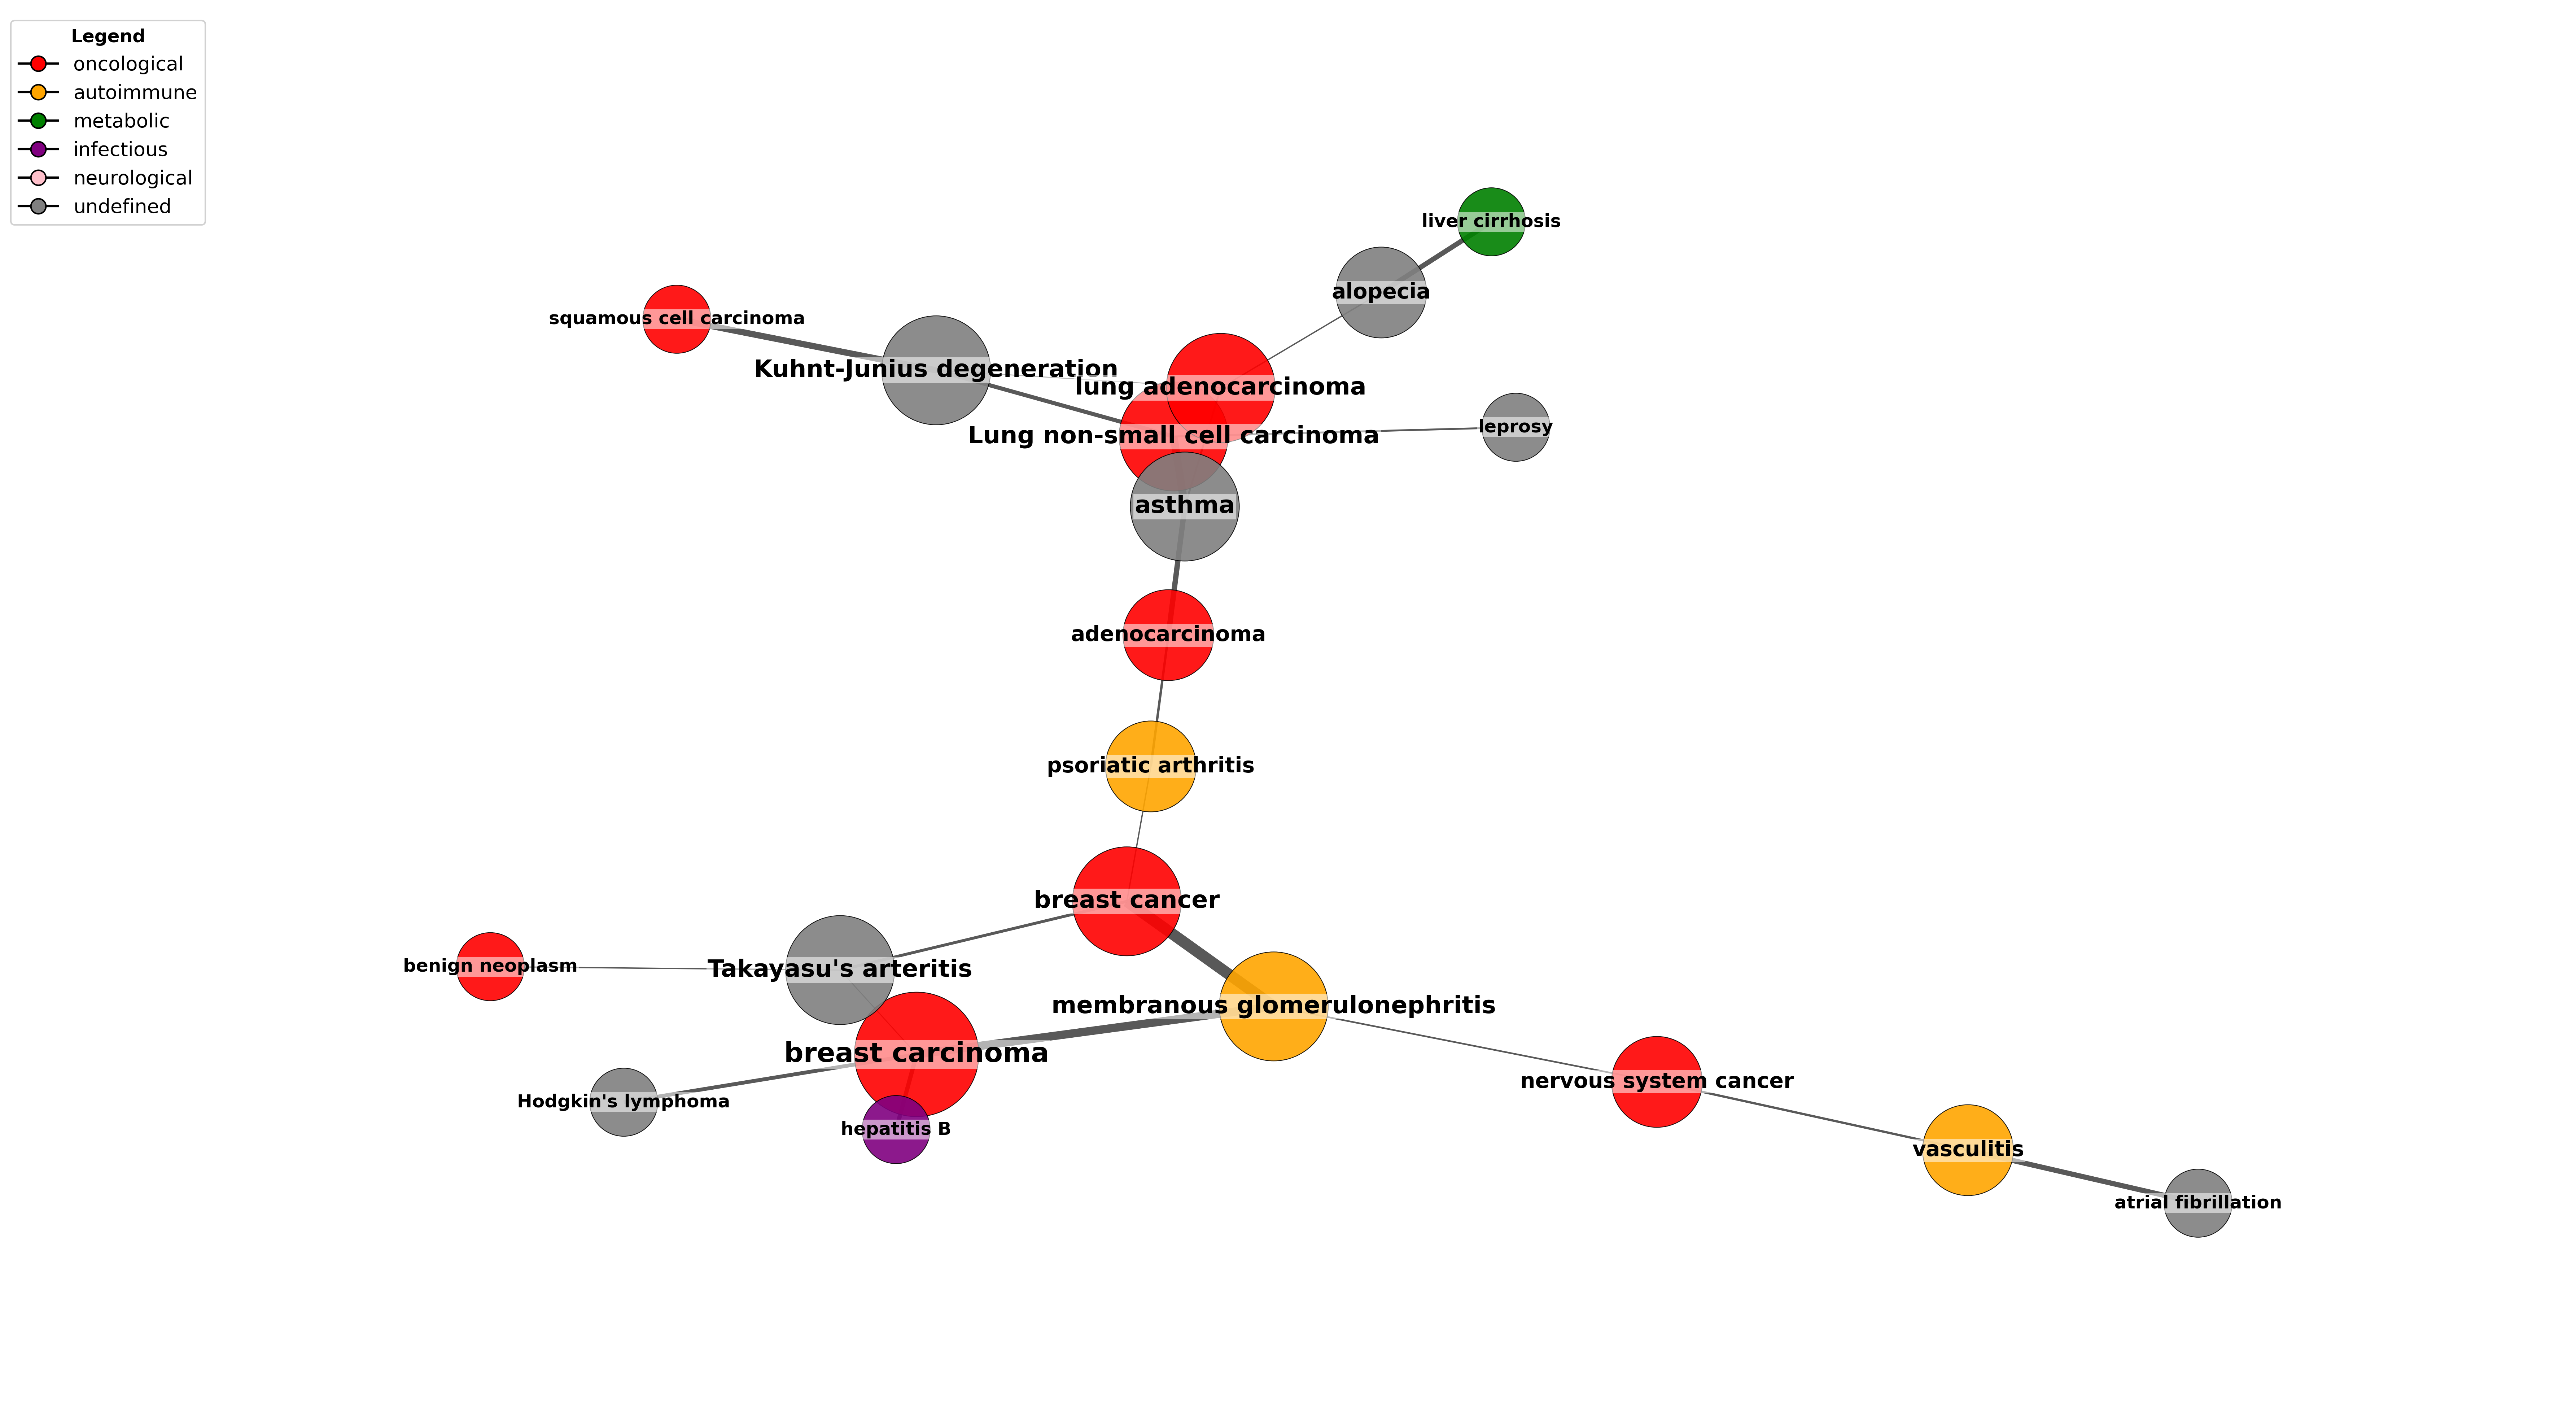

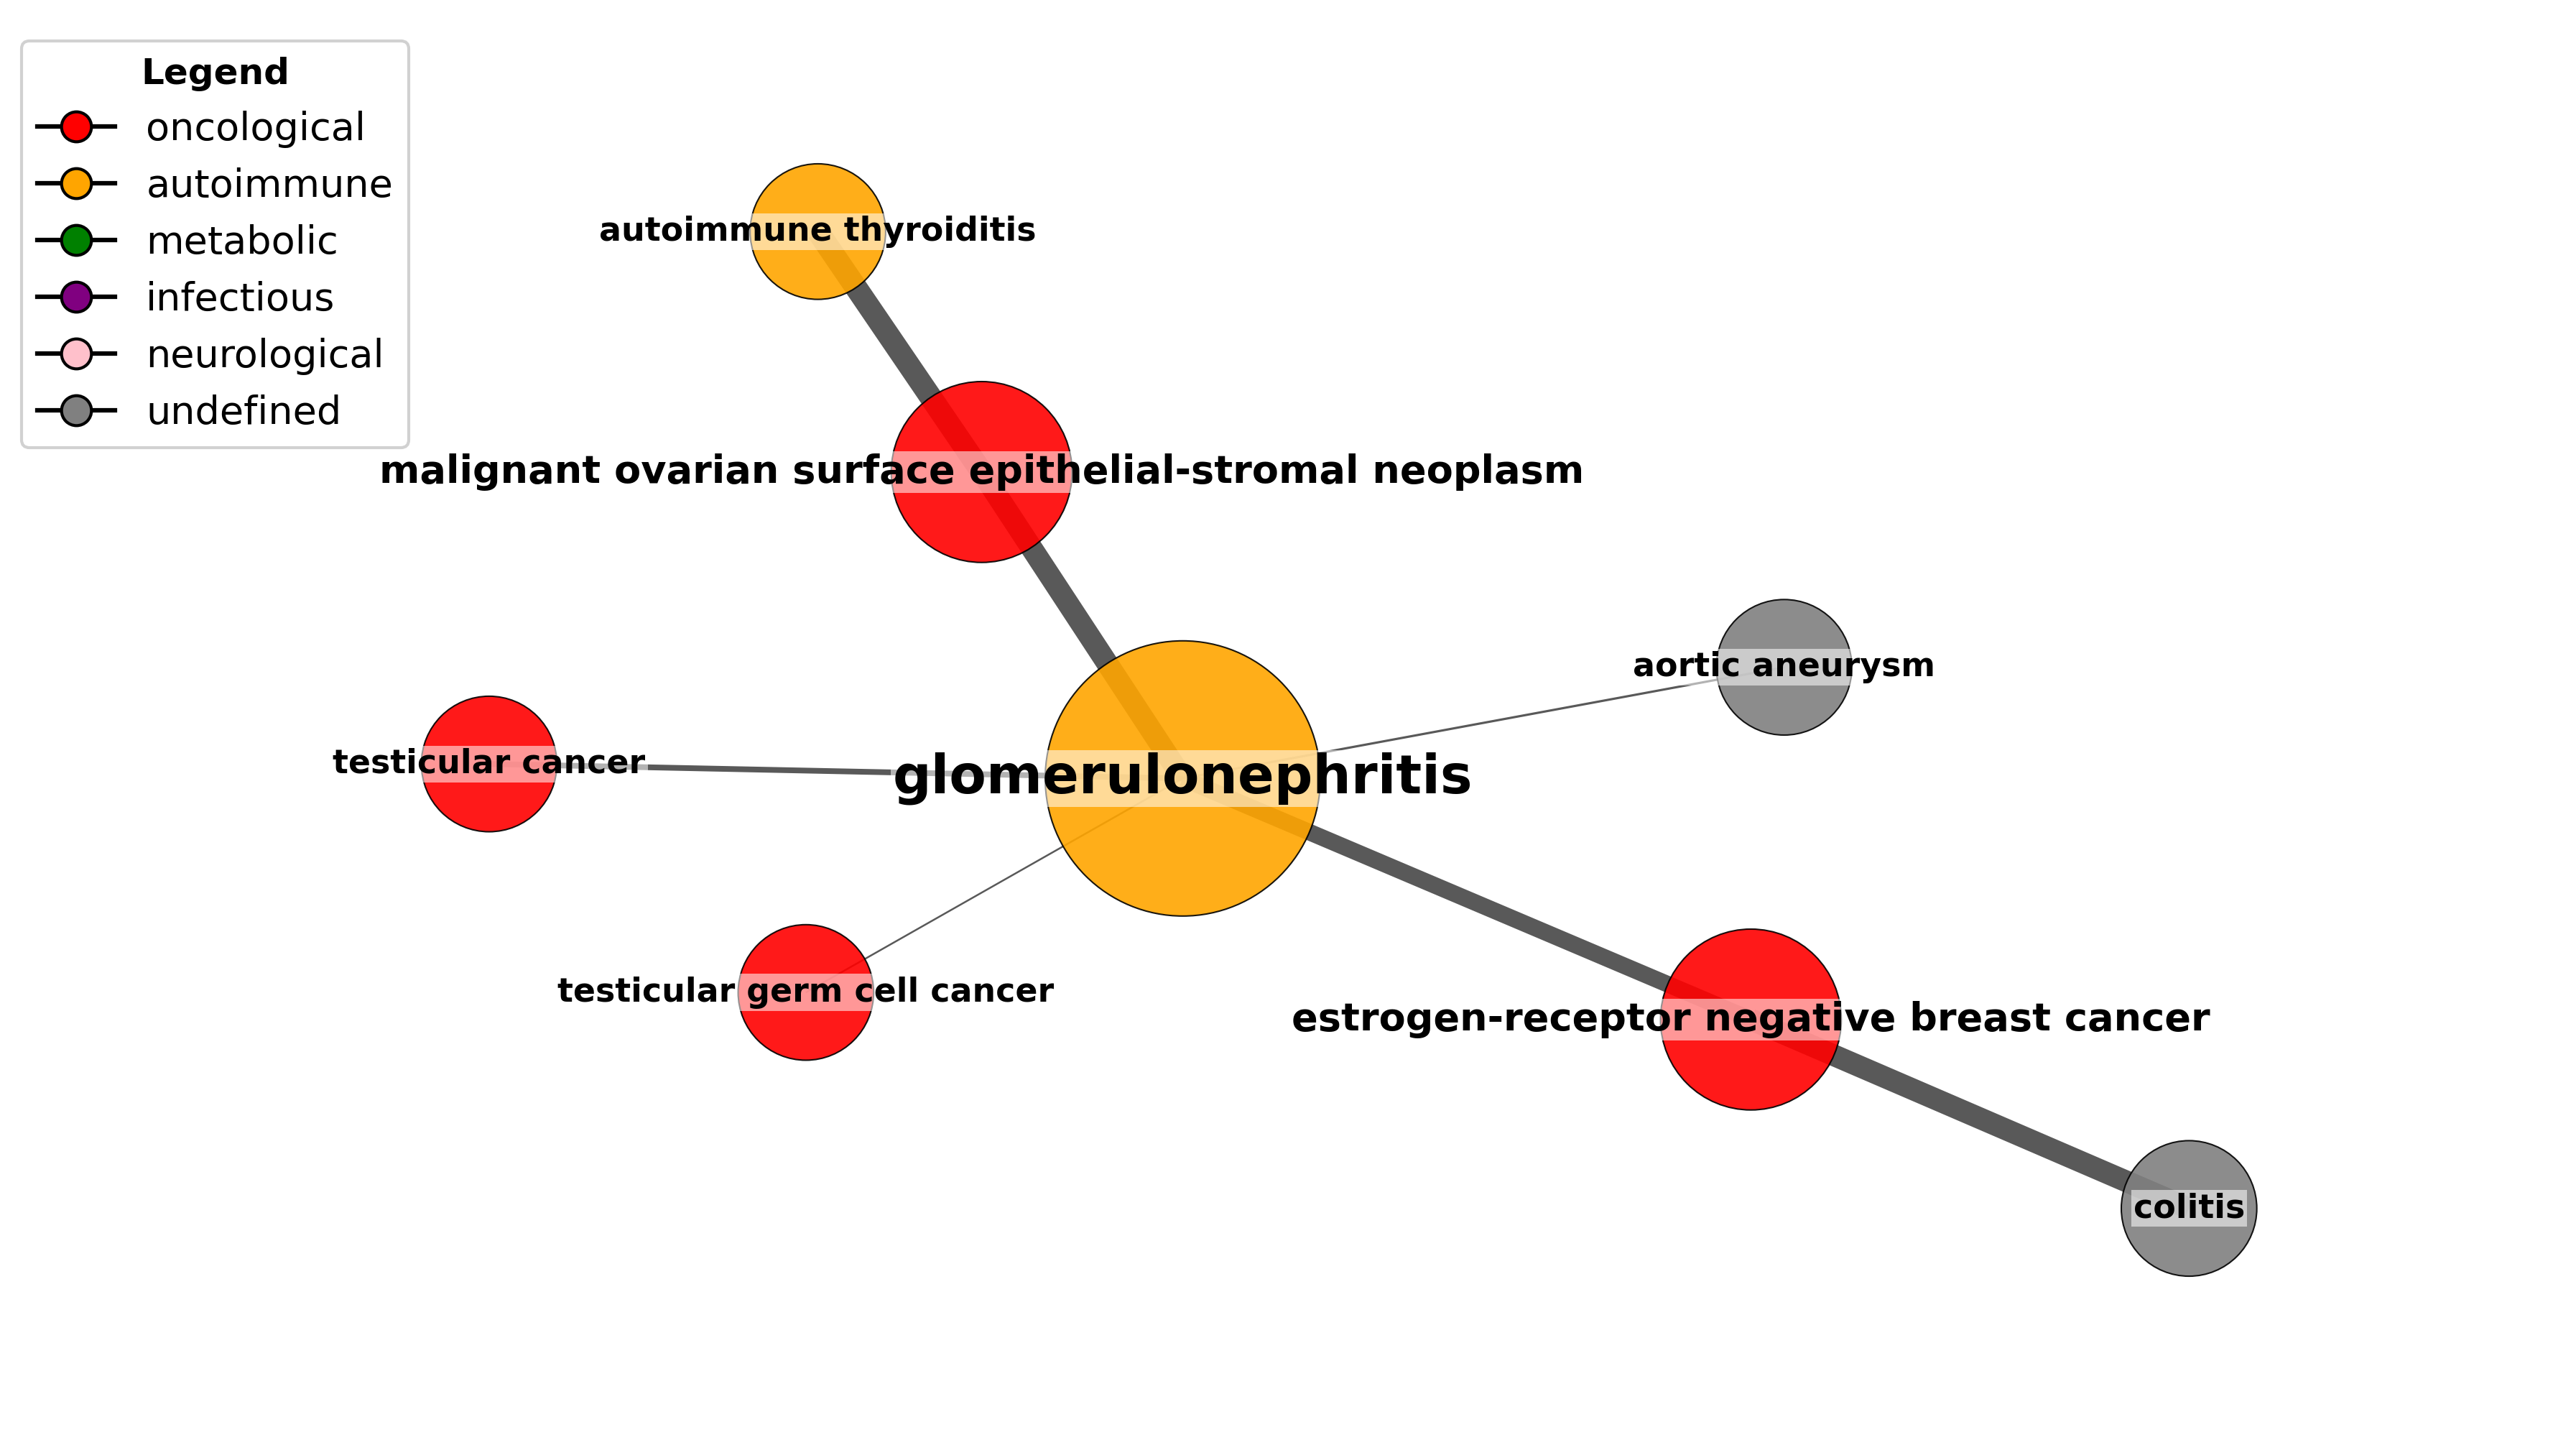

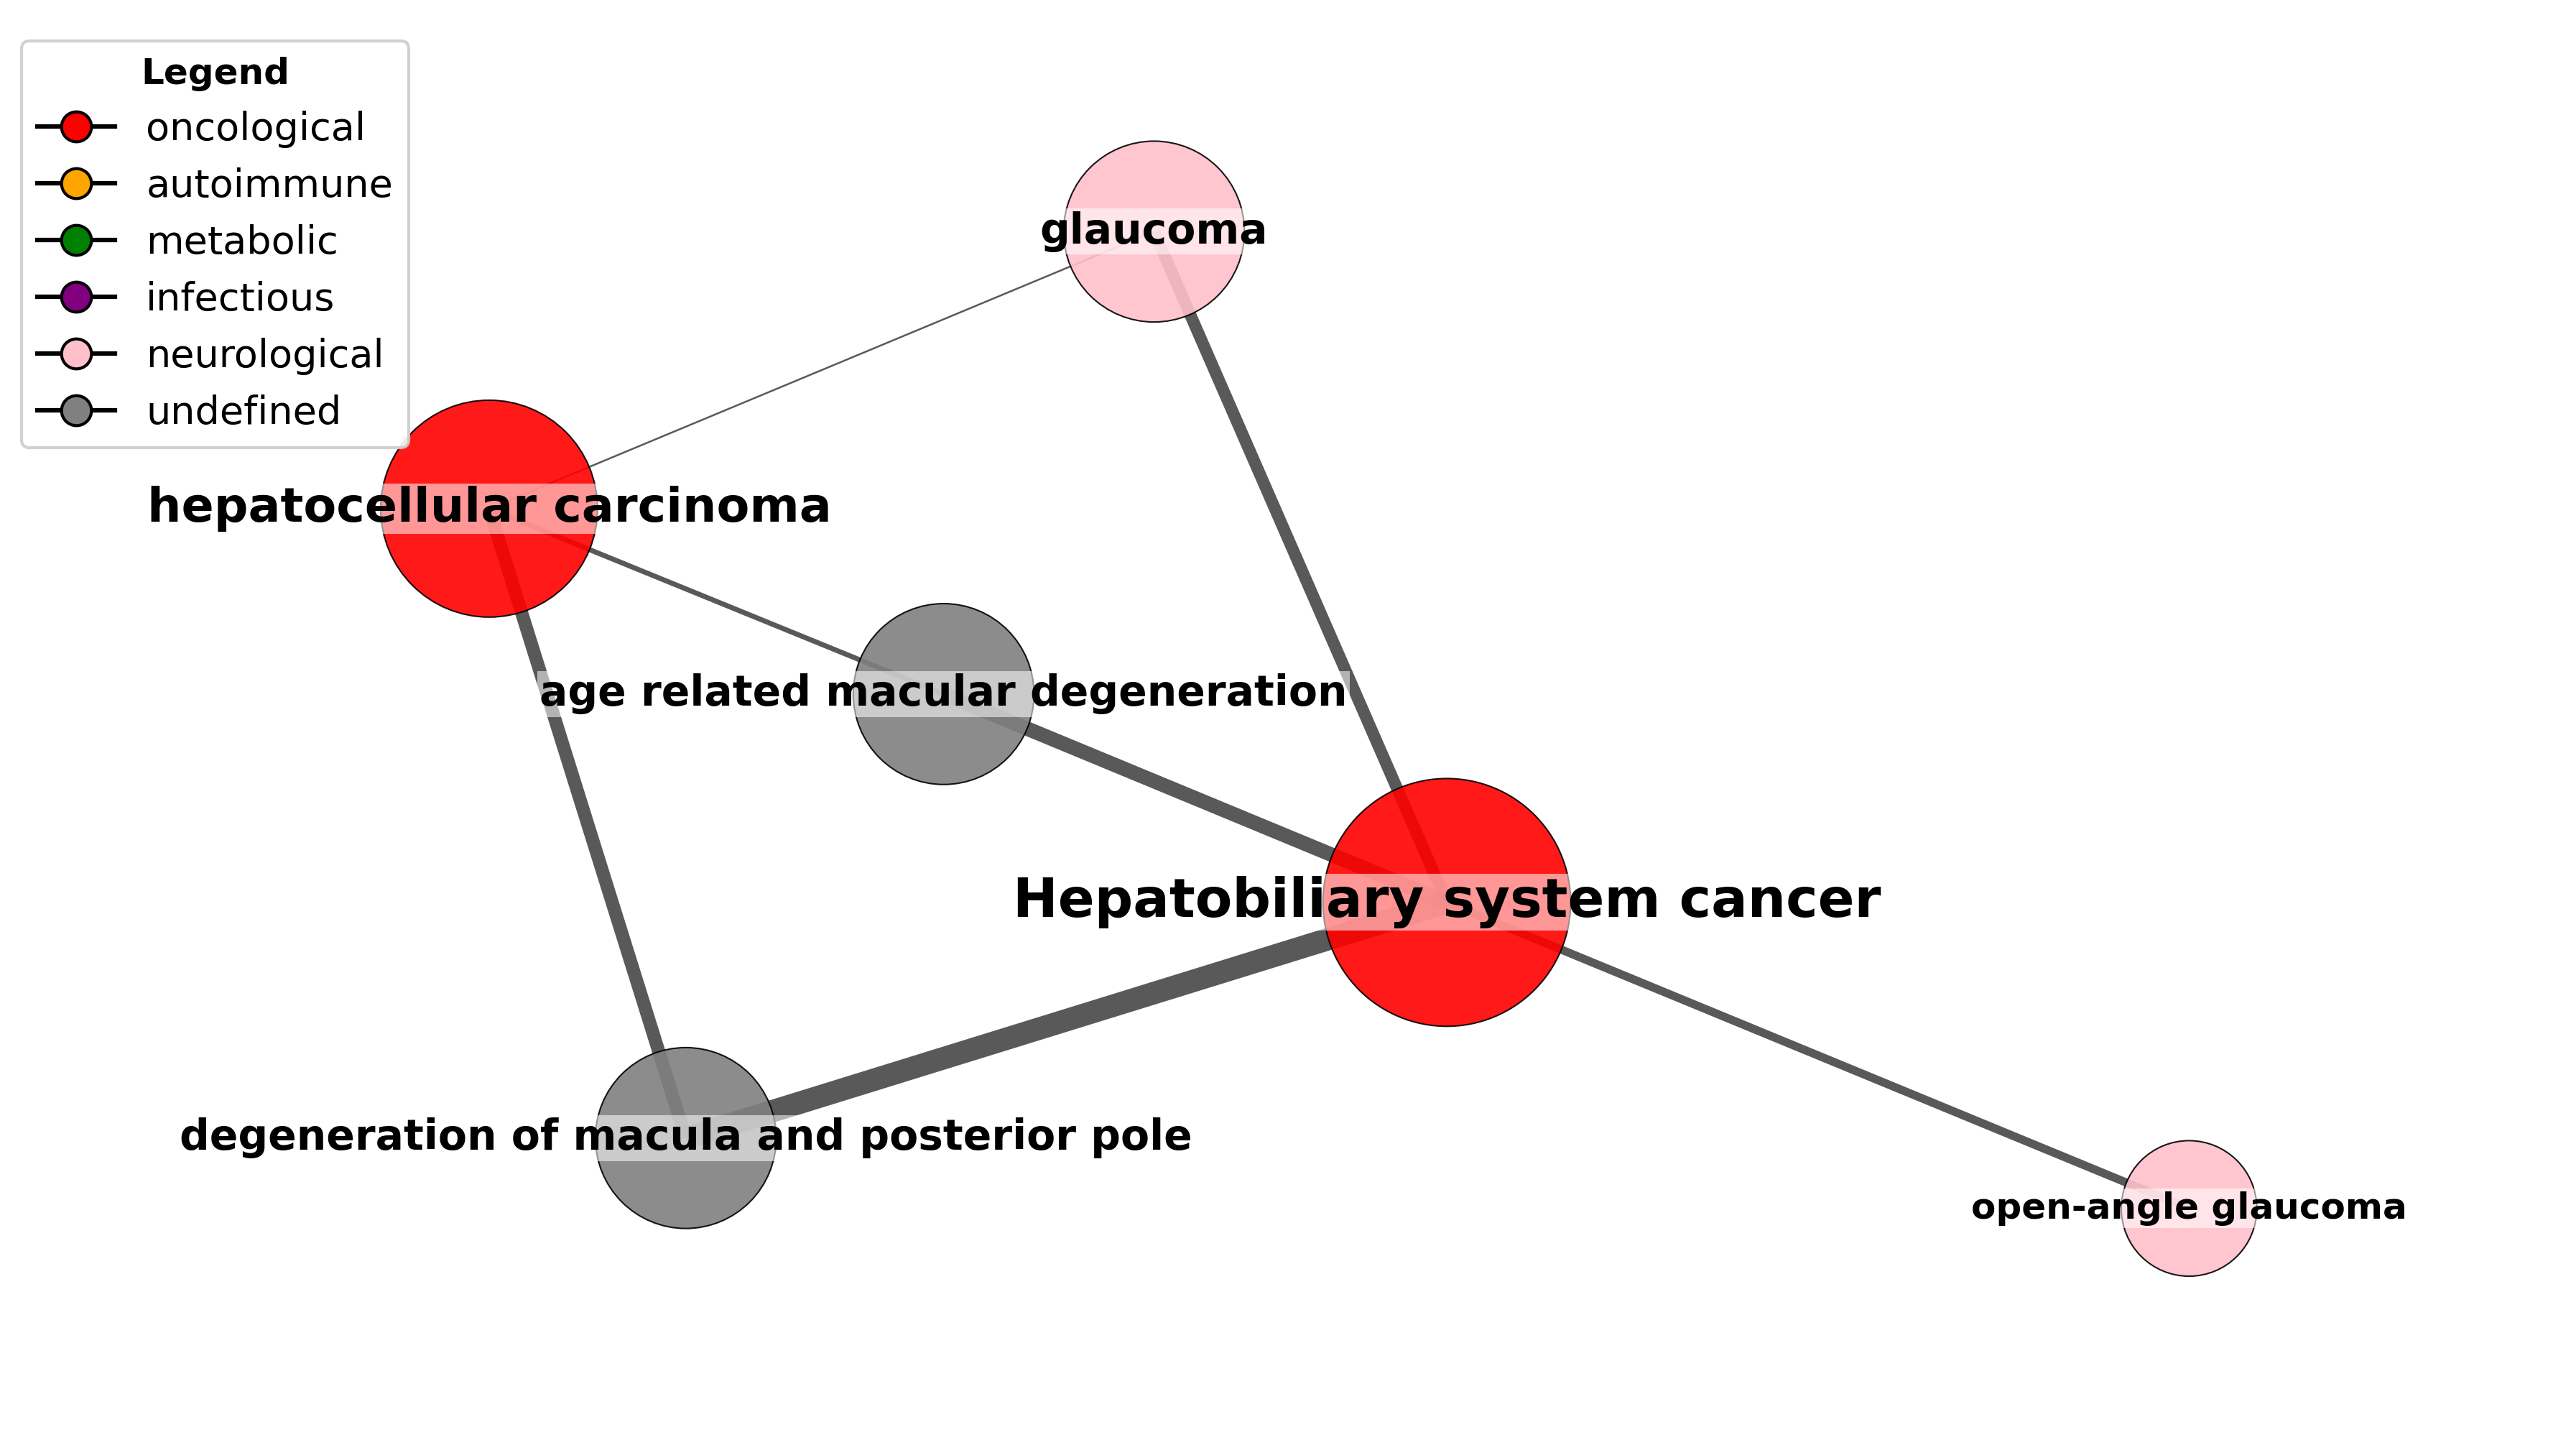

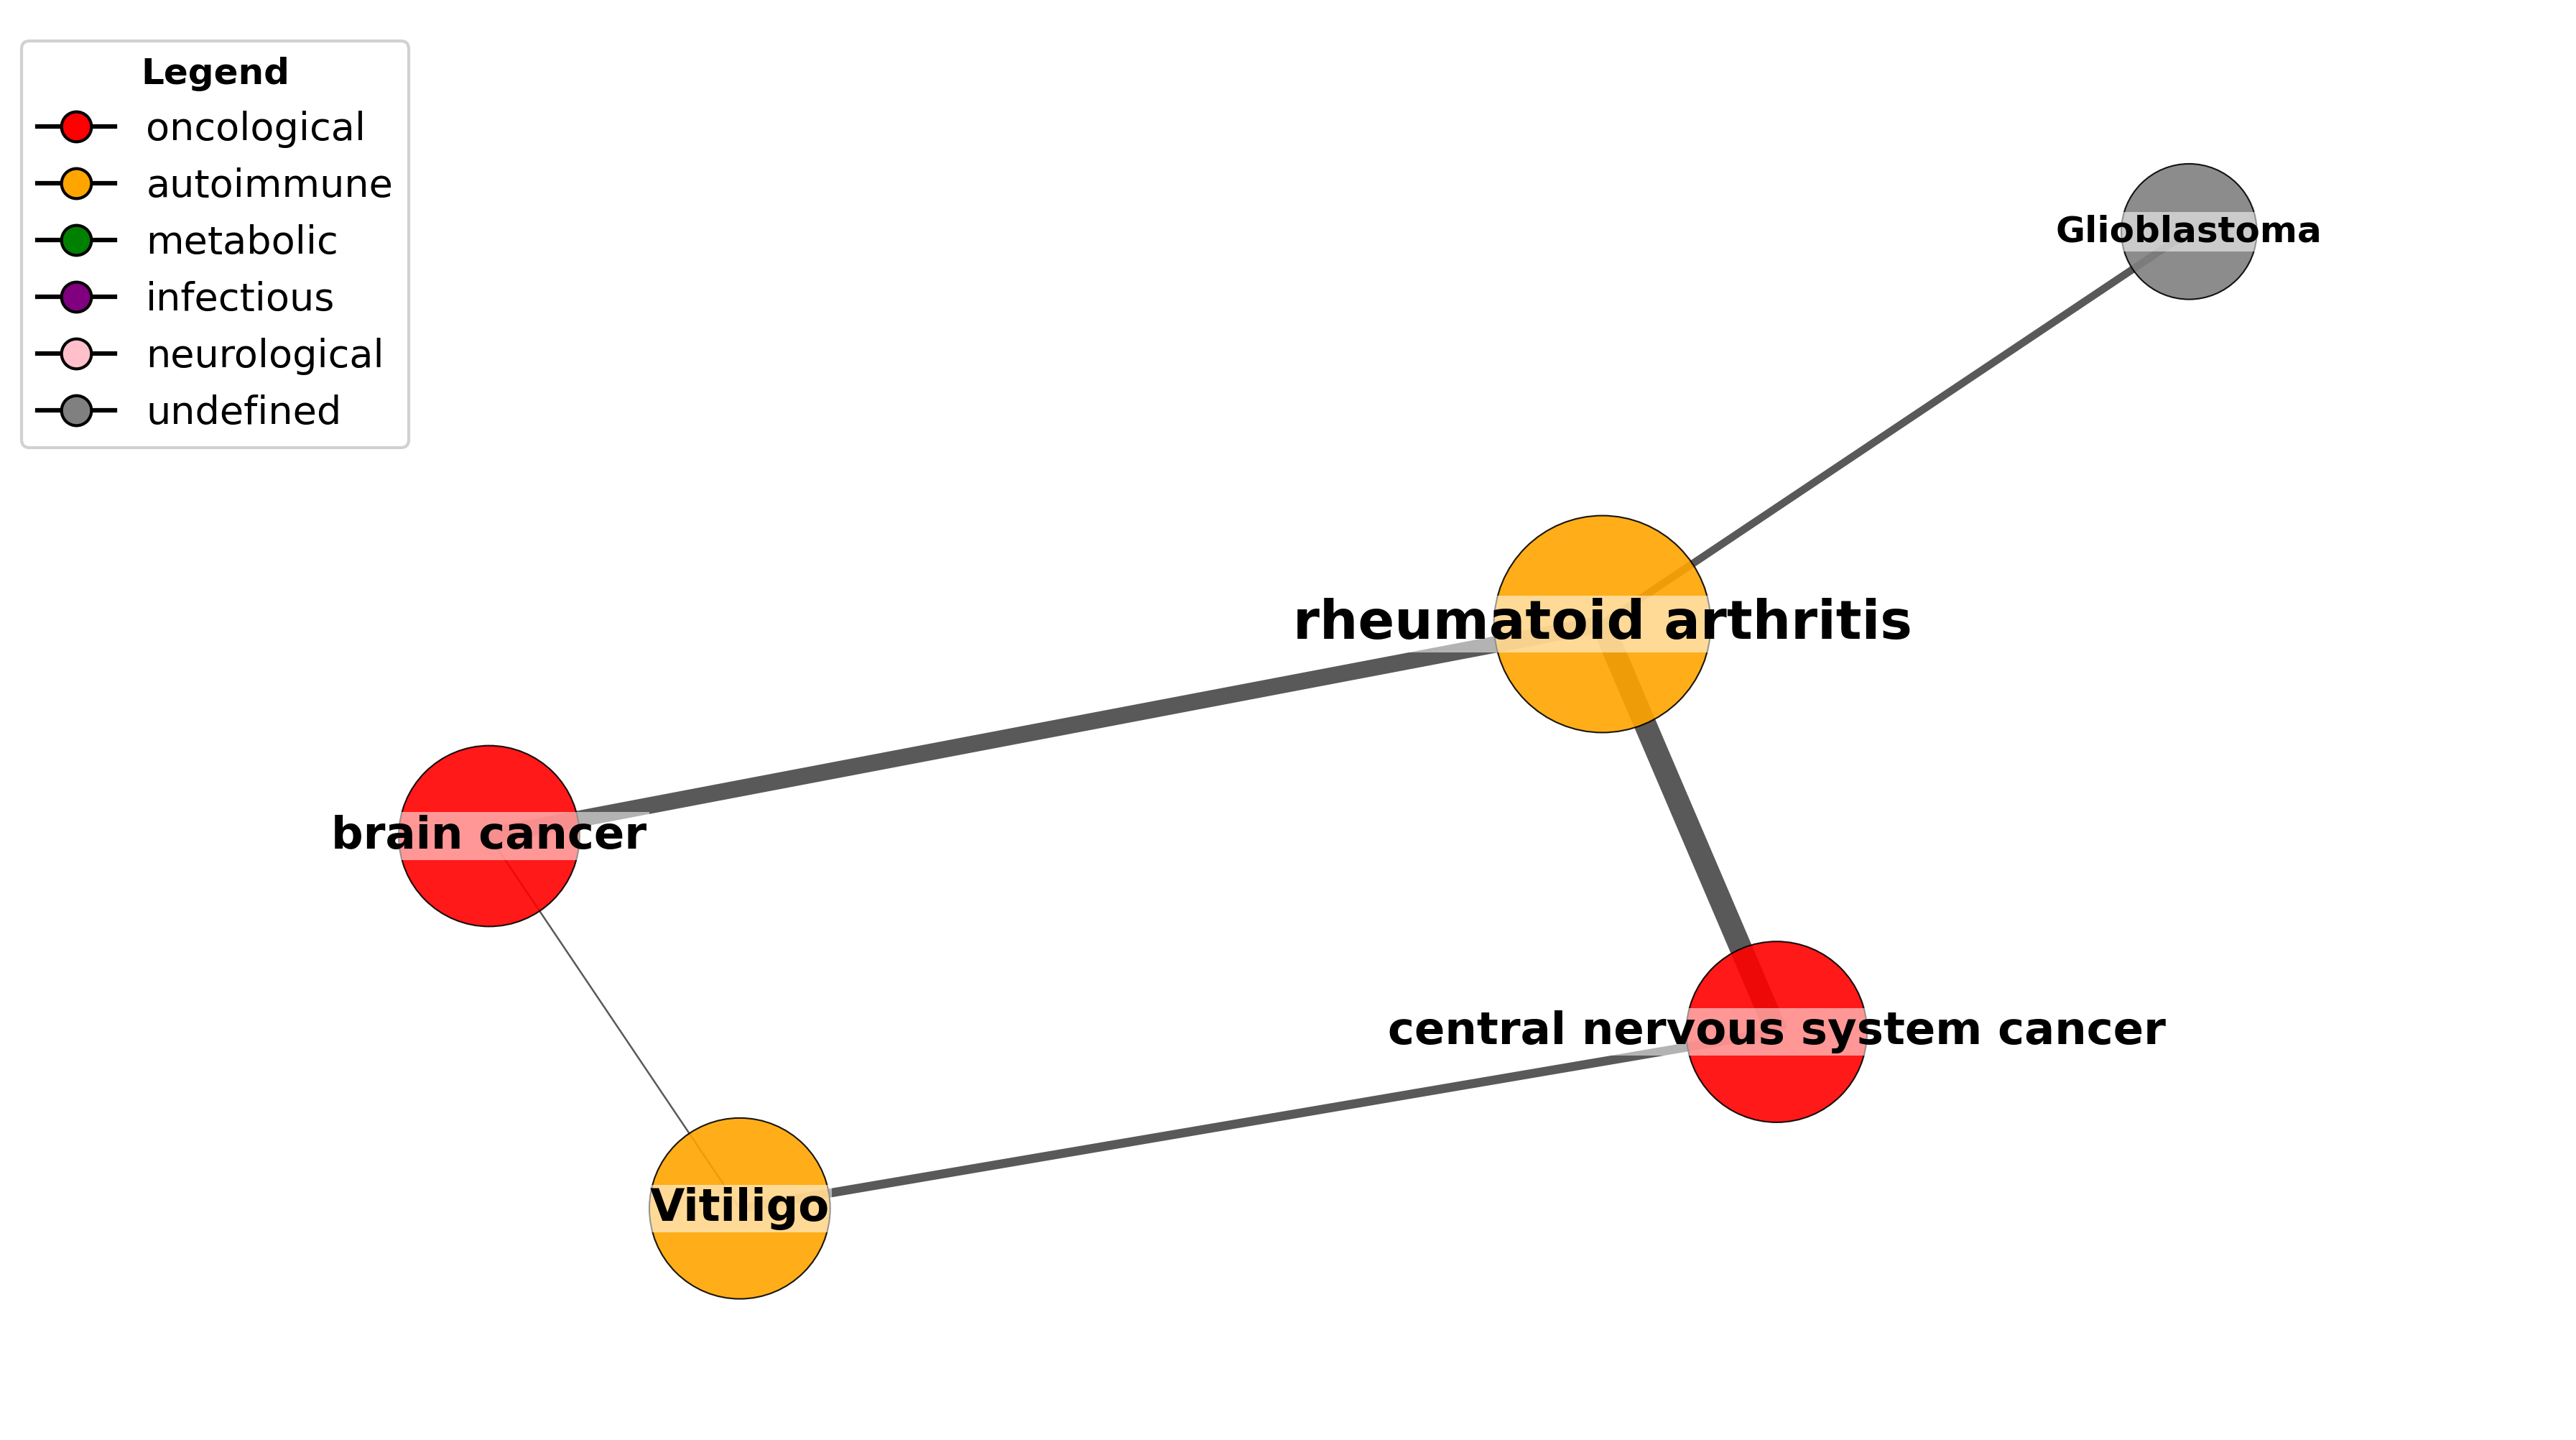

In [40]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

G_cross = nx.Graph()
for _, row in df_cross.iterrows():
    d1, d2, w = row["Disease_1"], row["Disease_2"], row["Balanced_Score"]
    G_cross.add_edge(d1, d2, weight=w)

color_map = {
    "oncological": "red",
    "autoimmune": "orange",
    "metabolic": "green",
    "infectious": "purple",
    "neurological": "pink",
    "undefined": "gray",
}

cat_map = pd.concat([
    df_cross[["Disease_1", "Category_1"]].rename(columns={"Disease_1": "Disease", "Category_1": "Category"}),
    df_cross[["Disease_2", "Category_2"]].rename(columns={"Disease_2": "Disease", "Category_2": "Category"})
]).drop_duplicates(subset="Disease")

disease_to_category = dict(zip(cat_map["Disease"], cat_map["Category"]))

for node in G_cross.nodes():
    G_cross.nodes[node]["category"] = disease_to_category.get(node, "undefined")

components = list(nx.connected_components(G_cross))

def draw_component(subgraph, fig_name):
    import random
    import matplotlib.lines as mlines

    num_nodes = len(subgraph.nodes())

    if num_nodes <= 6:
        k_val = 0.3  
    elif num_nodes <= 12:
        k_val = 0.6 
    else:
        k_val = 1.2 

    pos = nx.spring_layout(
        subgraph,
        k=k_val,
        iterations=6000,
        weight='weight',
        seed=6
    )

    fig_width = max(12, min(26, num_nodes * 1.2))
    fig_height = fig_width * 0.6
    plt.figure(figsize=(fig_width, fig_height), dpi=300)

    node_sizes = [450 + 1600 * subgraph.degree(n) for n in subgraph.nodes()]
    node_colors = [color_map[subgraph.nodes[n]["category"]] for n in subgraph.nodes()]

    weights = np.array([w['weight'] for _, _, w in subgraph.edges(data=True)])
    edge_widths = np.interp(np.log1p(weights), (np.log1p(weights.min()), np.log1p(weights.max())), (0.6, 7.5))
    nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color='black', alpha=0.65)

    degrees = dict(subgraph.degree())
    max_deg = max(degrees.values()) if degrees else 1
    font_sizes = {n: int(10 + 8 * (degrees[n] / max_deg)) for n in subgraph.nodes()}

    for n, (x, y) in pos.items():
        plt.text(
            x, y, n,
            fontsize=font_sizes[n],
            fontweight="bold",
            color="black",
            ha="center", va="center",
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.55, pad=0.8)
        )

    nx.draw_networkx_nodes(
        subgraph, pos,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.9,
        edgecolors="black", linewidths=0.5
    )

    legend_elements = [
        mlines.Line2D([], [], color='black', marker='o', markersize=10,
                      markerfacecolor=col, label=cat)
        for cat, col in color_map.items()
    ]
    legend = plt.legend(handles=legend_elements, loc="upper left",
                        bbox_to_anchor=(-0.05, 1.0),
                        title="Legend", fontsize=13,
                        title_fontsize=12, frameon=True, framealpha=0.9)
    legend.get_title().set_fontweight('bold')

    plt.subplots_adjust(left=0.03, right=0.97, top=0.93, bottom=0.03)
    plt.margins(0.15)
    plt.axis("off")
    plt.show(block=False)
    plt.pause(1)

big_components = []
small_components = []

for comp in components:
    if len(comp) > 5:
        big_components.append(comp)
    else:
        small_components.append(comp)

for i, comp in enumerate(big_components, start=1):
    subgraph = G_cross.subgraph(comp)
    draw_component(subgraph, f"Cross-domain Network – Large Component {i}")

block_size = 1  
for i in range(0, len(small_components), block_size):
    comp_group = small_components[i:i + block_size]
    nodes_in_group = set().union(*comp_group)
    subgraph = G_cross.subgraph(nodes_in_group)
    draw_component(subgraph, f"Cross-domain Network – Small Group {i//block_size + 1}")

In [41]:
from itertools import chain
bridge_counts = Counter(chain.from_iterable(df_cross['Bridge_List']))
bridge_counts.most_common(30)

[('sleep disorder', 40),
 ('developmental disorder of mental health', 40),
 ('specific developmental disorder', 40),
 ('attention deficit hyperactivity disorder', 40),
 ('autism spectrum disorder', 40),
 ('cognitive disorder', 40),
 ('gastrointestinal system cancer', 40),
 ('prostate cancer', 40),
 ('reproductive organ cancer', 40),
 ('male reproductive organ cancer', 40),
 ('arthritis', 40),
 ('immune system cancer', 40),
 ('female reproductive organ cancer', 40),
 ('Respiratory Allergy', 40),
 ('lung cancer', 40),
 ('psoriasis', 40),
 ('skin carcinoma', 40),
 ('restless legs syndrome', 40),
 ('integumentary system cancer', 40),
 ('carbohydrate metabolic disorder', 40),
 ('uterine cancer', 40),
 ('respiratory system cancer', 40),
 ('inherited metabolic disorder', 40),
 ('hypertension', 40),
 ('basal cell carcinoma', 40),
 ('hypothyroidism', 40),
 ('hematologic cancer', 40),
 ('Depressive disorder', 39),
 ('mood disorder', 39),
 ('endocrine gland cancer', 39)]

In [42]:
gene_counts = Counter(chain.from_iterable(df_cross['Genes_Along_Path']))
gene_counts.most_common(10)

[(('DMRTA1', 'HLA-DQA1'), 364),
 (('DMRTA1', 'HLA-DRB1'), 364),
 (('TERT', 'HLA-DQA1'), 286),
 (('TERT', 'HLA-DRB1'), 286),
 (('DMRTA1', 'HLA-DQA2'), 286),
 (('CLPTM1L', 'HLA-DQA1'), 286),
 (('CLPTM1L', 'HLA-DRB1'), 286),
 (('SLC6A18', 'HLA-DQA1'), 286),
 (('SLC6A18', 'HLA-DRB1'), 286),
 (('DMRTA1', 'HLA-B'), 280)]